In [1]:
import numpy as np
import torch
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm.notebook import tqdm
from typing import Optional

/home/sasha/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:

class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

In [3]:
from src.methods.bayes.variational.distribution import LogNormVarDist

In [4]:
p = nn.Parameter(torch.tensor([0.0, 1.0]))
LogNormVarDist.from_parameter(p)

LogNormVarDist(param_mus: torch.Size([2]), param_std_log: torch.Size([2]), scale_mus: torch.Size([2]), scale_alphas_log: torch.Size([2]))

In [5]:
from src.methods.bayes.variational.net import BayesVarLogNormModule, VarBayesModuleNet
from src.methods.bayes.variational.optimization import NormLogVarKLLoss


In [6]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [7]:
module = Classifier()

In [9]:
#bayes_model = BayesModule(module)
var_module = BayesVarLogNormModule(module)
bayes_model = VarBayesModuleNet(module, nn.ModuleList([var_module]))

In [10]:
print(bayes_model)

VarBayesModuleNet(
  (module_list): ModuleList(
    (0): BayesVarLogNormModule(
      (base_module): Classifier(
        (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (fc1): Linear(in_features=3136, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=10, bias=True)
      )
      (posterior_params): ParameterList(
          (0): Object of type: ParameterDict
          (1): Object of type: ParameterDict
          (2): Object of type: ParameterDict
          (3): Object of type: ParameterDict
          (4): Object of type: ParameterDict
          (5): Object of type: ParameterDict
          (6): Object of type: ParameterDict
          (7): Object of type: ParameterDict
        (0): ParameterDict(
            (param_mus): Parameter containing: [torch.Floa

In [10]:
cnt = 0
for i, p in enumerate(bayes_model.parameters()):
    cnt += 1
print(cnt)

32


In [11]:
a = torch.tensor([[0, 2.], [3, 0]])
b =  torch.tensor([1., 1.])
a_s = a.to_sparse()
print(a_s @ b)

tensor([2., 3.])


In [12]:
optimizer = optim.Adam(bayes_model.parameters(), lr=0.1)

In [13]:
bayes_model.prior

{'conv1.weight': None,
 'conv1.bias': None,
 'conv2.weight': None,
 'conv2.bias': None,
 'fc1.weight': None,
 'fc1.bias': None,
 'fc2.weight': None,
 'fc2.bias': None}

In [14]:
image, label = test_dataset[10]
y = bayes_model(torch.ones_like(image))
kl_loss = NormLogVarKLLoss()
bayes_model.prior
out = y.sum() + kl_loss(bayes_model.weights, bayes_model.posterior, bayes_model.prior)
optimizer.zero_grad() 
out.backward() 
optimizer.step() 

In [15]:
bayes_model.prune({'threshold': -2.2})

In [16]:
bayes_model.set_map_params()

In [17]:
bayes_model.state_dict()

OrderedDict([('module_list.0.base_module.conv1.weight',
              tensor([[[[ 1.1844e-01,  4.5523e-02,  7.7357e-02],
                        [ 1.2347e-01, -2.6245e-02,  5.9424e-02],
                        [-1.9541e-01, -1.0627e-01,  1.7120e-01]]],
              
              
                      [[[ 1.7133e-01, -1.4804e-01,  2.0309e-01],
                        [-5.6071e-02,  1.8278e-01,  9.7331e-04],
                        [-1.6134e-01, -3.9905e-02,  2.2836e-01]]],
              
              
                      [[[ 5.3678e-02, -3.0544e-02, -8.0431e-02],
                        [ 2.0331e-01,  6.1189e-02, -2.8807e-04],
                        [-3.1414e-02, -7.0633e-02,  5.7627e-02]]],
              
              
                      [[[ 8.2146e-02,  3.4919e-02,  1.9072e-01],
                        [-3.1004e-02, -2.0766e-01,  5.0840e-02],
                        [-9.1758e-02, -6.1640e-02,  5.4968e-02]]],
              
              
                      [[[-1.6828e-01

In [18]:
print(bayes_model(torch.zeros_like(image)))
#print(bayes_model(torch.zeros_like(image), sample = False))
print(module(torch.zeros_like(image)))

tensor([[ -85.7760, -106.7544,  -96.7422,  -81.3685,  -84.2318,  -89.9381,
          -88.0232, -110.8953,  -90.5372, -101.8154]],
       grad_fn=<AddmmBackward0>)
tensor([[ -85.7760, -106.7544,  -96.7422,  -81.3685,  -84.2318,  -89.9381,
          -88.0232, -110.8953,  -90.5372, -101.8154]],
       grad_fn=<AddmmBackward0>)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda')

In [11]:
from src.methods.bayes.variational.trainer import VarBayesTrainer, VarTrainerParams, Beta_Scheduler_Plato, CallbackLossAccuracy
from src.methods.report.base import ReportChain
from src.methods.report.variational import VarBaseReport

In [12]:
beta = Beta_Scheduler_Plato()

In [22]:
x = torch.tensor([1., 2.], requires_grad=True)
print(x)
y = x ** 2
print(y)
z = nn.Parameter(y)
l = z.sum()
print(z)
l.backward()
print(z)
print(x)

tensor([1., 2.], requires_grad=True)
tensor([1., 4.], grad_fn=<PowBackward0>)
Parameter containing:
tensor([1., 4.], requires_grad=True)
Parameter containing:
tensor([1., 4.], requires_grad=True)
tensor([1., 2.], requires_grad=True)


In [15]:
BATCH_SIZE=1000
EPOCHS=4000
LR = 5e-4 #5e-4
# Split the training set into training and validation sets 
VAL_PERCENT = 0.2 # percentage of the data used for validation 
SAMPLES = 10
BETA = 0.01 #5e-5
BETA_FAC = 5e-1
PRUNE = 2.1#1.99, 2.1
PLATO_TOL = 20

base_module = Classifier()
var_module = BayesVarLogNormModule(base_module)
model = VarBayesModuleNet(base_module, nn.ModuleList([var_module]))


optimizer = optim.Adam(model.parameters(), lr=LR)

fit_loss = nn.CrossEntropyLoss() 
kl_loss = NormLogVarKLLoss()

beta = Beta_Scheduler_Plato(BETA, BETA_FAC, PLATO_TOL)
beta_KL = Beta_Scheduler_Plato(beta.beta, 1 / BETA_FAC, PLATO_TOL, ref = beta, threshold=1e-4)
def post_train_step(trainer: VarTrainerParams, train_result: VarBayesTrainer.TrainResult):
    beta.step(train_result.fit_loss)
    beta_KL.step(train_result.dist_loss)
    trainer.params.beta = float(beta)
    
#print(model.base_module.state_dict().keys())
val_size    = int(VAL_PERCENT * len(train_dataset)) 
train_size  = len(train_dataset) - val_size 
#ВЫНЕСТИ В ПАРАМЕТРЫ ТРЕЙНЕРА
t_dataset, v_dataset = torch.utils.data.random_split(train_dataset,  
                                                        [train_size,  
                                                            val_size]) 

# Create DataLoaders for the training and validation sets 
train_loader = torch.utils.data.DataLoader(t_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=True, 
                                        pin_memory=True) 
eval_loader = torch.utils.data.DataLoader(v_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=False, 
                                        pin_memory=True) 

model.to(device) 
train_params = VarTrainerParams(EPOCHS, optimizer,fit_loss, kl_loss, SAMPLES, PRUNE, BETA, {'accuracy': CallbackLossAccuracy()})
trainer = VarBayesTrainer(train_params, ReportChain([VarBaseReport()]), train_loader, eval_loader, [post_train_step])
trainer.train(model)

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch [1/4000],Loss:30393.142578125, KL Loss: 3039092.5. FitLoss: 2.221675157546997,Accuracy:0.25153750000000014,Validation Loss:30378.298828125,Validation Accuracy:0.754, Prune parameters: 21950.0/421642,Beta: 0.01


KeyboardInterrupt: 

In [16]:
base_module.state_dict()

OrderedDict()

In [26]:
torch.save(model.state_dict(), 'model_bayes.pt' )

In [31]:
model.prune({'threshold': 1.9})
print(model.prune_stats())

tensor(409356., device='cuda:0')


In [ ]:
model.prune([{'threshold': -2.2}])
print(model.prune_stats())

tensor(47343., device='cuda:0')


In [17]:
module = Classifier()
var_module = BayesVarLogNormModule(module)
model = VarBayesModuleNet(module, nn.ModuleList([var_module]))

In [18]:
model.state_dict()

OrderedDict([('module_list.0.posterior_params.0.param_mus',
              tensor([[[[-0.2737, -0.0213, -0.1784],
                        [-0.0449,  0.1339,  0.2884],
                        [ 0.1757,  0.2454,  0.0318]]],
              
              
                      [[[-0.2829,  0.1125,  0.2672],
                        [-0.0329,  0.1954,  0.2326],
                        [-0.0857, -0.2534,  0.0893]]],
              
              
                      [[[ 0.1525,  0.0669, -0.2533],
                        [-0.1758,  0.1672,  0.1206],
                        [ 0.0153,  0.1936, -0.3305]]],
              
              
                      [[[ 0.0107,  0.3182,  0.2102],
                        [-0.1029,  0.3132, -0.2125],
                        [-0.2650,  0.0061,  0.2422]]],
              
              
                      [[[-0.1922,  0.1445, -0.1445],
                        [-0.1862, -0.1703,  0.1814],
                        [-0.3061, -0.1629,  0.1818]]],
              


In [19]:
model.load_state_dict(torch.load('model_bayes.pt'))
image1, label1 = test_dataset[10]
image2, label2 = test_dataset[11]
model(image1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [27]:
val_loss = 0.0
val_acc = 0.0
PRUNE = 1.0
test_loader = torch.utils.data.DataLoader(test_dataset,  
                                         batch_size=BATCH_SIZE,  
                                         shuffle=False, 
                                         pin_memory=True) 
kl_loss = NormLogVarKLLoss()
trainer.params.prune_threshold = PRUNE
test_result = trainer.eval(model, test_loader)
acc = test_result.custom_losses['val_accuracy']
print(f'Loss:{test_result.val_loss}, KL Loss: {test_result.dist_loss}, FitLoss: {test_result.fit_loss}, Accuracy {acc}, Prune parameters: {test_result.cnt_prune_parameters}/{test_result.cnt_params}')

Loss:16906.90234375, KL Loss: 1690681.375, FitLoss: 0.09073139727115631, Accuracy 0.98, Prune parameters: 221821.0/421642


In [32]:
model.to(device=device)
model.prune({'threshold': 1.0})
model.set_map_params()


In [33]:
print(model.base_module.conv1.weight)

Parameter containing:
tensor([[[[ 4.2992e-03, -5.4342e-01, -0.0000e+00],
          [ 3.9089e-01, -0.0000e+00, -0.0000e+00],
          [ 8.2518e-01,  3.0815e-01, -2.3478e-02]]],


        [[[ 9.8153e-02,  0.0000e+00, -0.0000e+00],
          [ 4.4879e-01,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00, -0.0000e+00]]],


        [[[-1.4131e+00, -7.5729e-01, -0.0000e+00],
          [ 2.0788e-01,  4.6619e-01,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  2.6288e-01]]],


        [[[ 0.0000e+00,  9.8380e-01,  3.4592e-01],
          [-0.0000e+00,  4.0430e-01,  0.0000e+00],
          [-8.4115e-01, -3.8792e-01, -1.5979e-01]]],


        [[[ 2.0565e-01,  0.0000e+00,  2.3229e-01],
          [ 0.0000e+00,  6.6020e-01,  0.0000e+00],
          [-0.0000e+00, -0.0000e+00, -3.2411e-01]]],


        [[[-0.0000e+00,  3.8068e-01,  0.0000e+00],
          [-1.7023e-03,  7.2274e-01,  1.6451e-01],
          [-2.6313e-01,  0.0000e+00, -8.0280e-02]]],


        [[[ 0.0000e+00,  7.1311e-01,

Label: 5


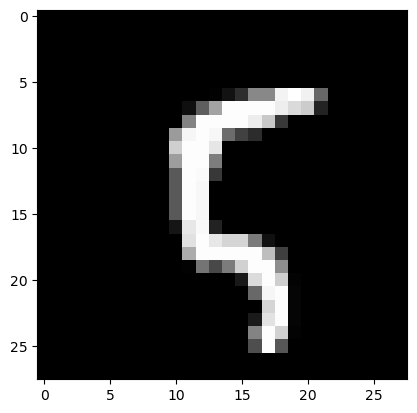

In [41]:
image, label = test_dataset[100]
plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
print('Label:', label)

In [42]:
torch.max(model(image.cuda()).data, 1)

torch.return_types.max(
values=tensor([2.1405], device='cuda:0'),
indices=tensor([5], device='cuda:0'))